In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

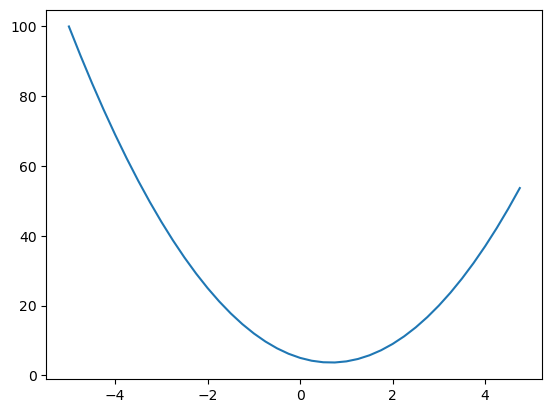

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys 
plt.plot(xs, ys)
plt.show()

In [5]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/ h

14.00000009255109

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# h = 0.0001
# # inputs
# a = 2.0
# b = -3.0
# c = 10.0

# d1 = a*b + c
# a += h
# d2 = a*b + c 

# print("d1", d1)
# print("d2", d2)
# print('slope', (d2-d1)/h)

# Infulence on b numerical output
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c 

print("d1", d1)
print("d2", d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [105]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp') 

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        




In [103]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [22]:
d._prev
d._op

'+'

In [28]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record')node for it
        dot.node(name = uid, label ="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

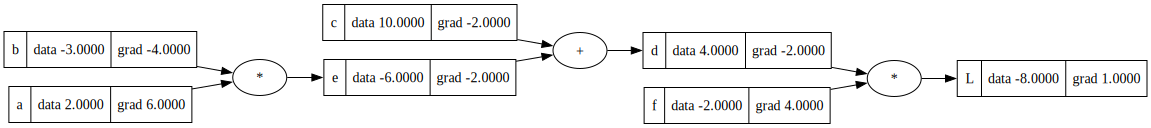

In [30]:
draw_dot(L)

Notes of backprop
L = d * f
woould like to know the derivative dL/dd, a derivative is (f(x+h) - f(x))/h...
...((d+h)*f - d*f)/h --> (d*f + h*f - d*f) / h --> (h*f)/h --> f

now I need to Understand dL / dc, but first what is dd / dc and dd / de, who know that d = c + e,understanding this gives us 1.0, this is shown below

(f(x+h) - f(x)) / h ---> ((c+h + e) - (c + e))/h ---> (c + h + e - c - e)/h ---> h/h --> 1.0

by symmetery dd / de would also be 1.0.

Using chain rule
we want: dL / dc = (dL / dd) * (dd / dc)
we know: dL/ dd, dd / dc, 

for the first node using chain rule
dL/ de = -2.0
e = a * b
de / da gives the value b, see first three lines for refresher
dL / da = (dL / de) * (de / da)




In [25]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [16]:
c.grad = -2.0
e.grad = -2.0

In [9]:
f.grad = 4.0
d.grad = -2

In [24]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label= 'c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0  , label='b')
    c = Value(10.0 , label= 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0  , label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 

    print((L2 - L1)/h)

lol()

-3.9999999999995595


# Backpropagate through a neuron

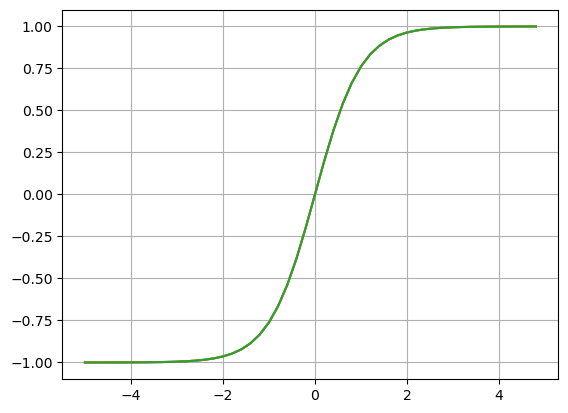

In [33]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [83]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



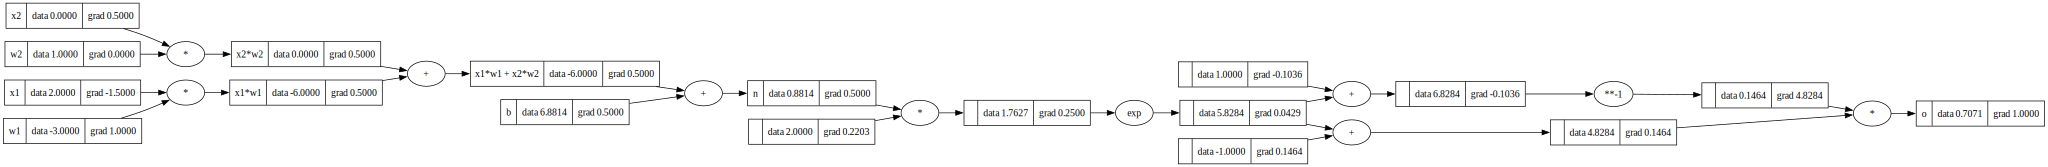

In [106]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e -1) / (e + 1)
# --- 
o.label = 'o'
o.backward()
draw_dot(o)

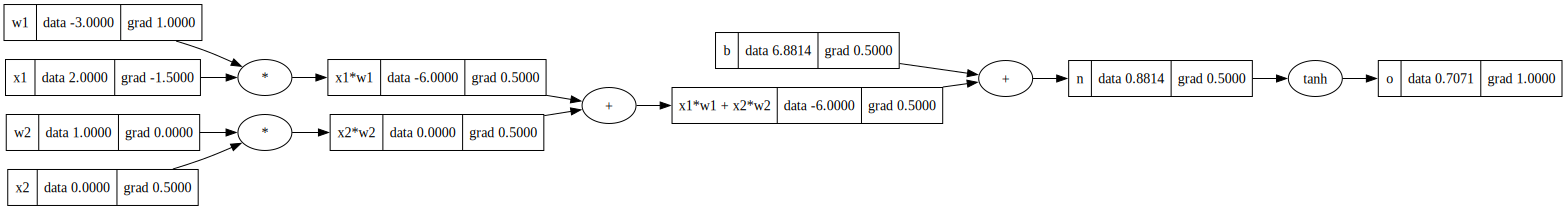

In [86]:
draw_dot(o)

In [85]:
o.backward()

In [79]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [76]:
# Using topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [68]:
o.grad = 1.0

In [69]:

# using the update value class
o._backward()

In [70]:
n._backward()

In [72]:
b._backward()

In [73]:
x1w1x2w2._backward()

In [74]:
x1w1._backward()
x2w2._backward()

In [54]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [52]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [50]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [46]:
n.grad = 0.5

In [48]:
o.grad = 1.0

In [42]:
1 - o.data**2 

0.4999999999999999

In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 ---> 1 - o**2

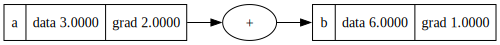

In [91]:
# Understanding bug
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

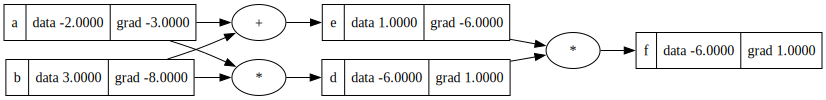

In [92]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'
f.backward()
draw_dot(f)

In [107]:
import torch



In [108]:
x1 = torch.Tensor([2.0]).double()    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()    ; w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
